For this project, you need to complete the following steps:

First, compute the camera calibration matrix and distortion coefficients given a set of chessboard images (in the camera_cal folder in the repository).

Next, for a series of test images (in the test_images folder in the repository):

1. Apply the distortion correction to the raw image.
2. Use color transforms, gradients, etc., to create a thresholded binary image.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Detect lane pixels and fit to find lane boundary.
5. Determine curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
8. Once you have implemented a successful pipeline on the test images, you will run your algorithm on a video. In the case of the video, you must search for the lane lines in the first few frames, and, once you have a high-confidence detection, use that information to track the position and curvature of the lines from frame to frame.
9. Check out the project rubric before you submit to make sure your project is complete!.

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import image_transformation  # my image transformation python file example
#import camera_calibration as cc  # my camera calibration python file example
%run camera_calibration # import my camera calibration python function
#%run image_transformation # include functions to test for
from image_transformation import warp
from image_transformation import plotImageSet
from image_transformation import region_of_interest
#img = mpimg.imread('stopsign.jpg')

#plotImageSet([img,])


In [2]:
# 0. Calibrate the camera using the calibration images
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y
mtx,dist = calibrate_camera('camera_cal/calibration*.jpg',nx, ny)

Calibrating camera... please be patient!
Camera calibrated using  17  out of  20  images!


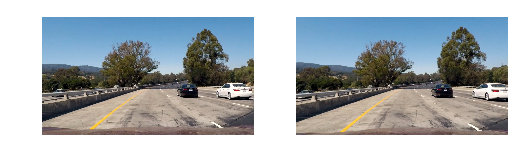

In [3]:
# 1 .Apply distortion correction to the raw image.
fname = 'test_images/test5.jpg'
img = mpimg.imread(fname)
undistorted_im = cv2.undistort(img, mtx, dist, None, mtx)

# display original and undistorted
plotImageSet([img,undistorted_im])

In [4]:
# 2. Use color transforms, gradients, etc., to create a thresholded binary image.

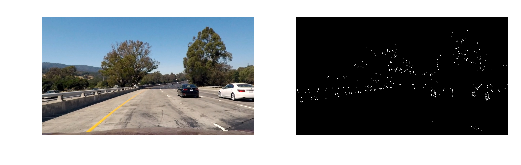

In [5]:

#0 change color space to HLS
image_hls = cv2.cvtColor(undistorted_im,cv2.COLOR_RGB2HLS)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Grayscale
    #1 convert to gray
    gray_im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply cv2.Sobel()
    if orient=='x':
        sobel = cv2.Sobel(gray_im, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray_im, cv2.CV_64F, 0, 1)   
    # Take the absolute value of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply lower and upper thresholds
    # Create binary_output
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

sxbinary = abs_sobel_thresh(undistorted_im,'x',3,(60,155))
plotImageSet([undistorted_im,sxbinary])

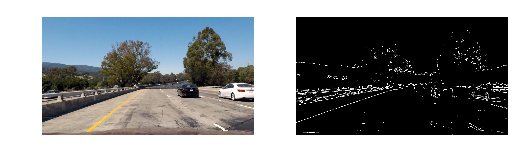

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray_im, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_im, cv2.CV_64F, 0, 1,ksize=sobel_kernel)   
    # 3) Calculate the magnitude 
    sobel_mag = np.sqrt((sobelx**2)+(sobely**2))
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # 6) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 7) Return this mask as your binary_output image
    return binary_output

mag_binary = mag_thresh(undistorted_im, 3,(60,150))
plotImageSet([undistorted_im,mag_binary])

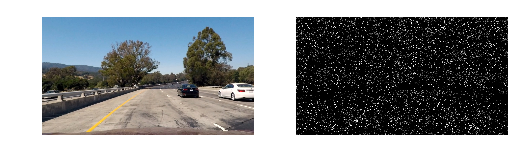

In [7]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray_im, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_im, cv2.CV_64F, 0, 1, ksize=sobel_kernel)  
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gradient_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gradient_dir)
    binary_output[(gradient_dir > thresh[0]) & (gradient_dir < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
dir_binary = dir_threshold(undistorted_im, sobel_kernel=15, thresh=(0.93, 1.04))
plotImageSet([undistorted_im,dir_binary])

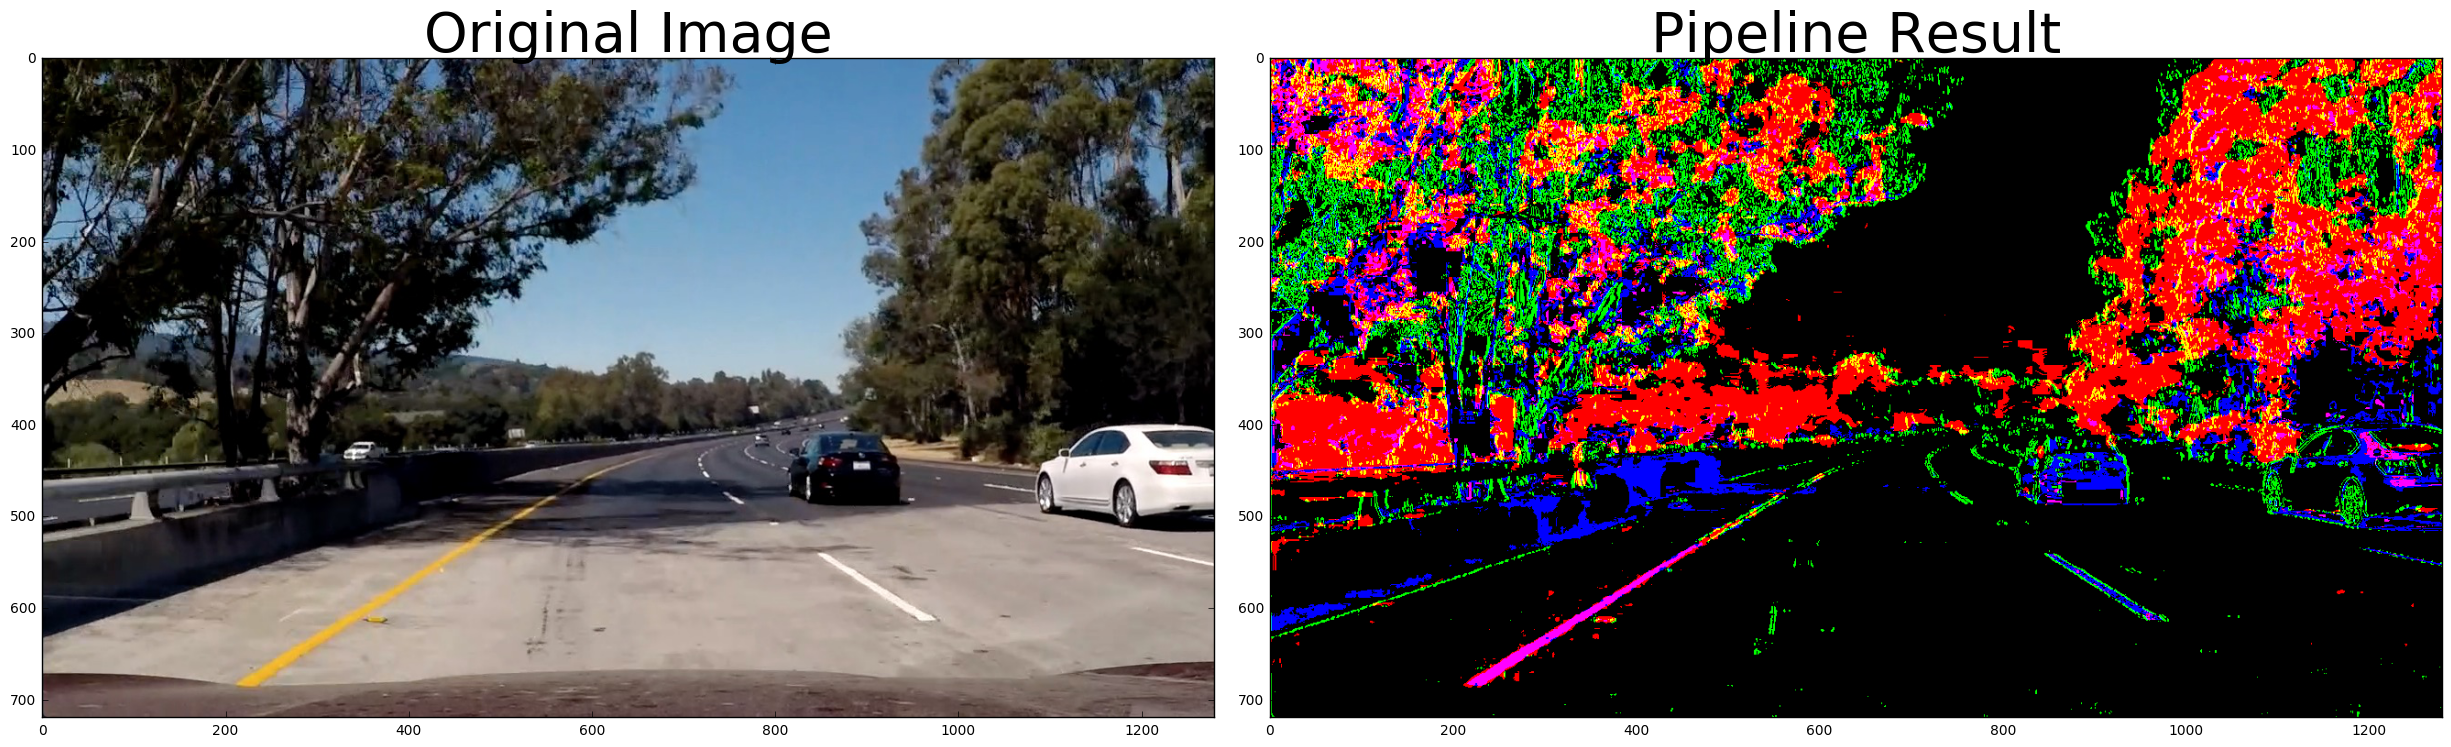

In [44]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('test_images/test5.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), r_thresh=(20, 100), h_thresh=(20, 100)):
    img = np.copy(img)
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    b_channel = img[:,:,2]
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel hue
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    #Threshold color channel r
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # Stack each channel
    
    color_binary = np.dstack(( h_binary, sxbinary, s_binary))
    return color_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 1280, 3)


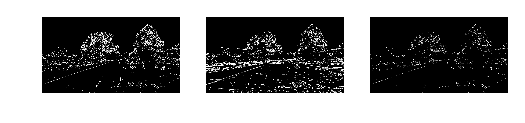

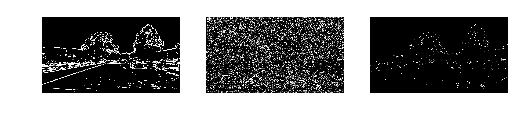

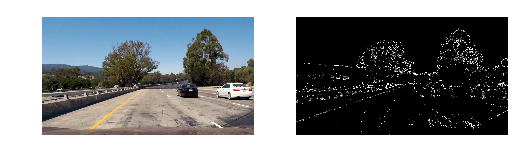

In [45]:
# image = mpimg.imread('signs_vehicles_xygrad.png')
fname = 'test_images/test1.jpg'
or_image = mpimg.imread(fname)
print(or_image.shape)
#undistorted_im = cv2.undistort(img, mtx, dist, None, mtx)
# Choose a Sobel kernel size
ksize = 19 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(or_image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(or_image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(or_image, sobel_kernel=ksize, mag_thresh=(40, 160))
t_min = (45.0/180.0)*np.pi # print(t_min)
t_max = (65.0/180.0)*np.pi # print(t_max)
dir_binary = dir_threshold(or_image, sobel_kernel=ksize, thresh=(t_min, t_max))
combined1 = np.zeros_like(dir_binary)
combined2 = np.zeros_like(dir_binary)
combined3 = np.zeros_like(dir_binary)
combined1[((gradx == 1) & (grady == 1))] = 1
combined2[((mag_binary == 1) & (dir_binary == 1))] = 1
combined3[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plotImageSet([gradx,grady,combined1])
plotImageSet([mag_binary,dir_binary,combined2])
plotImageSet([or_image,combined3,])

In [46]:
gray_im = combined3


#2 apply gaussian blur to smoothen the image
kernel_size = 5; #should be an odd number
image_gaus = gaussian_blur(gray_im, kernel_size);

#3 apply canny filter
low_threshold =50;
high_threshold = 200;
image_canny = canny(image_gaus, low_threshold, high_threshold);

#4 apply mask
imshape = image_canny.shape;
vertices = np.array([[(0,imshape[0]),(imshape[1]/2,imshape[0]*4/7), (imshape[1], imshape[0])]], dtype=np.int32);
image_mask = region_of_interest(image_canny, vertices);

#5 apply Hough transform
rho = 2 # distance resolution in pixels of the Hough grid
theta = 1*np.pi/180 # angular resolution in radians of the Hough grid
threshold = 25     # 25 minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #15 minimum number of pixels making up a line
max_line_gap = 70   #3 maximum gap in pixels between connectable line segments
lower_x = 0;
upper_x = imshape[1];
lower_y = imshape[0]*4/7;
upper_y = imshape[0];
image_hough = hough_lines(image_mask, rho, theta, threshold, min_line_length, max_line_gap);

#6 annotated image
image_annotated = weighted_img(image_hough, undistorted_im);


#proc_im = process_image(undistorted_im)
plotImageSet([undistorted_im,image_annotated])

point1 =  0.46875  x width,  0.5555555555555556  x height point2 =  0.5729166666666666  x width 0.5555555555555556  x height
720 , 1280


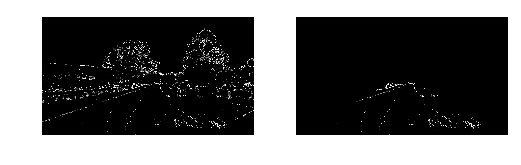

In [47]:
#720 x 1280
#540 x 960
print('point1 = ', 450/960,' x width, ', 300/540,' x height', 'point2 = ', 550/960,' x width',300/540,' x height')
# apply 1st mask to select region of interest
height, width = combined3.shape
#combined3 = 1- np.zeros_like(combined3)
print (height,',',width)
vertices = np.array([[(0,height),(width*0.45,0.55*height),(width*0.55, 0.55*height), (width, height)]], dtype=np.int32);
image_mask = region_of_interest(combined3*255, vertices);
plotImageSet([combined3*255,image_mask])
img = image_mask

In [38]:
print(image_mask[530:531,800:870])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


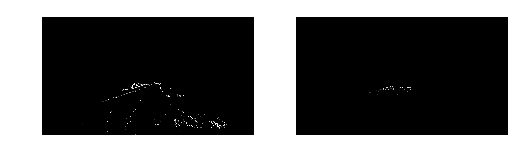

In [39]:
# compute the perspective transform M

#four source coordinates
src = np.float32(
#     [[470,310],
#      [490,310],
#      [855,540],
#      [140,540]])
    [[420,350],
     [550,350],
     [700,450],
     [295,450]])
    
# 960 x 540
#     four desired coordinates
dst = np.float32(
#     [[140,320],
#     [855,320],
#     [855,540],
#     [140,540]])
    [[360,350],
    [625,350],
    [625,450],
    [360,450]])
#img = mpimg.imread('stopsign.jpg')
# fname = 'test_images/solidWhiteRight.jpg'
# img = mpimg.imread(fname)

warped_img = warp(img,src,dst,0)
plotImageSet([img,warped_img])
#warped_back = warp(warped_img,src,dst,1)
#plotImageSet([img,warped_img,warped_back])

In [40]:
def get_histogram (img):
    hist = []
    x = []
    height, width = img.shape
    for i in range(width):
        count = 0
        for j in range(height):
            if img[j,i]>0:
                count = count + 1
        hist.append(count)
        x.append(i)
    return x,hist

In [41]:
def get_peak(image):
    # use that region to search for the line in the next section of the image
    x,y = get_histogram(image)
    # find peaks
    peak_x = y.index(max(y)) #get the x coordinate for the peak on the left
    return peak_x

In [42]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [43]:
import copy
# 4. Detect lane pixels and fit to find lane boundary.
# create mask
original_height, original_width = warped_img.shape
step_height = round(original_height/5)
left_search_point = round(original_width/4)
right_search_point = round(3*original_width/4)
left_amplitude = round(original_width/4) 
right_amplitude = round(original_width/4)
line_img = copy.copy(warped_img)
for i in range(5):
    
    image = warped_img[(original_height-step_height*(i+1)):(original_height-step_height*(i)),0:original_width]
    height, width = image.shape
    
    region_left  = image[0:height,(left_search_point-left_amplitude):(left_search_point+left_amplitude)]
    x1=(left_search_point-left_amplitude)
    x2=(left_search_point+left_amplitude)
    y1=(original_height-step_height*(i+1))
    y2=(original_height-step_height*(i))    

                     #(img, (x1, y1), (x2, y2), color, thickness)
    cv2.rectangle(line_img, (x1, y1), (x2, y2), (100,100,100), 2)
    left_peak_x = left_search_point - left_amplitude + get_peak(region_left)
    
    region_right = image[0:height,(right_search_point-right_amplitude):(right_search_point+right_amplitude)]
    x1=(right_search_point-right_amplitude)
    x2=(right_search_point+right_amplitude)
    y1=(original_height-step_height*(i+1))
    y2=(original_height-step_height*(i))
    
    cv2.rectangle(line_img, (x1, y1), (x2, y2), (100,100,100), 2)
    right_peak_x = right_search_point - right_amplitude + get_peak(region_right)

    left_search_point = left_peak_x
    right_search_point = right_peak_x
    left_amplitude = 100
    right_amplitude = 100
    
#     print (left_peak_x,right_peak_x)
    
im = weighted_img(line_img,warped_img)    
plotImageSet([im,])

ValueError: max() arg is an empty sequence

In [ ]:
# 5. Determine curvature of the lane and vehicle position with respect to center.


In [ ]:
# 6. Warp the detected lane boundaries back onto the original image.


In [ ]:
# 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.